In [1]:
import json
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import pandas as pd

/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load the Best Probe Weights

In [4]:
# Path to your results
RESULTS_DIR = "../results/DATA/SR_DATA/MATH/Qwen2-1.5B-Instruct_Qwen2-1.5B-Instruct_maxlen_3000_k_1_temp_0.0"
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"

# Load best probe data
with open(f"{RESULTS_DIR}/best_probe_predictions.json", 'r') as f:
    best_probe = json.load(f)

probe_weights = np.array(best_probe['probe_weights'])  # [D] dimension vector
best_layer = best_probe['best_layer']
best_position = best_probe['best_position']
cv_score = best_probe['cv_score']
test_score = best_probe['test_score']

print(f"Best probe: Layer {best_layer}, Position {best_position}")
print(f"CV Score: {cv_score:.4f}, Test Score: {test_score:.4f}")
print(f"Probe weights shape: {probe_weights.shape}")

Best probe: Layer 17, Position -2
CV Score: 0.8481, Test Score: 0.8236
Probe weights shape: (1536,)


## 2. Load Model and Extract Embedding Matrix

In [5]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
vocab_size = len(tokenizer)
print(f"Vocabulary size: {vocab_size}")

# Load model to get embeddings
print("Loading model (this may take a moment)...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="cpu",  # Keep on CPU for analysis
)

# Get embedding matrix
embedding_matrix = model.get_input_embeddings().weight.data.cpu().float().numpy()  # [vocab_size, d_model]
print(f"Embedding matrix shape: {embedding_matrix.shape}")

`torch_dtype` is deprecated! Use `dtype` instead!


Vocabulary size: 151646
Loading model (this may take a moment)...
Embedding matrix shape: (151936, 1536)
Embedding matrix shape: (151936, 1536)


## 3. Compute Dot Products with All Tokens

In [6]:
# Compute dot product: embedding_matrix @ probe_weights
# This tells us how much each token "activates" the probe direction
dot_products = embedding_matrix @ probe_weights  # [vocab_size]

print(f"Dot products shape: {dot_products.shape}")
print(f"Min: {dot_products.min():.4f}, Max: {dot_products.max():.4f}, Mean: {dot_products.mean():.4f}")

Dot products shape: (151936,)
Min: -1.3172, Max: 1.4348, Mean: 0.1368


## 4. Find Top Tokens (Highest Activations)

In [7]:
# Get top K tokens with highest dot products
TOP_K = 50

top_indices = np.argsort(dot_products)[-TOP_K:][::-1]  # Descending order
top_scores = dot_products[top_indices]
top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

# Create DataFrame
top_df = pd.DataFrame({
    'rank': range(1, TOP_K + 1),
    'token_id': top_indices,
    'token': top_tokens,
    'dot_product': top_scores,
})

print(f"\n{'='*60}")
print(f"TOP {TOP_K} TOKENS (Highest Activation)")
print(f"{'='*60}\n")
print(top_df.to_string(index=False))


TOP 50 TOKENS (Highest Activation)

 rank  token_id           token  dot_product
    1     96658 .RelativeLayout     1.434792
    2     84663        imbledon     1.257121
    3    114966            控股集团     1.227685
    4    101841               敞     1.220458
    5    110680              半个     1.215778
    6     68376           atham     1.209608
    7     62336     MessageType     1.199264
    8    110187              外包     1.187168
    9    115702               趾     1.181483
   10     56026           Glide     1.181084
   11     76555     DataService     1.172549
   12    121818               癃     1.170612
   13     22550            Rank     1.162594
   14      3878            avel     1.156171
   15     10663               �     1.152252
   16     91057           combe     1.147371
   17     40180        Delegate     1.135334
   18    108685             举办的     1.135121
   19    119652               纥     1.133324
   20    115241              殖民     1.131310
   21     85030   

## 5. Find Bottom Tokens (Lowest Activations)

In [8]:
# Get bottom K tokens (most negative)
bottom_indices = np.argsort(dot_products)[:TOP_K]
bottom_scores = dot_products[bottom_indices]
bottom_tokens = [tokenizer.decode([idx]) for idx in bottom_indices]

bottom_df = pd.DataFrame({
    'rank': range(1, TOP_K + 1),
    'token_id': bottom_indices,
    'token': bottom_tokens,
    'dot_product': bottom_scores,
})

print(f"\n{'='*60}")
print(f"BOTTOM {TOP_K} TOKENS (Lowest Activation)")
print(f"{'='*60}\n")
print(bottom_df.to_string(index=False))


BOTTOM 50 TOKENS (Lowest Activation)

 rank  token_id       token  dot_product
    1     99854           阵    -1.317245
    2    114821         被执行    -1.087894
    3     83708         uos    -1.073630
    4     46523     puzzles    -1.011686
    5    104431          防止    -0.984070
    6       254           �    -0.979545
    7     99688           遇    -0.959983
    8     80773      sockfd    -0.956365
    9     75634         OSE    -0.952105
   10    111709           杖    -0.939044
   11     96436       ]bool    -0.929312
   12    113236          牵引    -0.899079
   13    103432          中秋    -0.897023
   14     72648    ++){\n\n    -0.879092
   15       457         ile    -0.877805
   16     11430     charged    -0.870488
   17     98000      .lwjgl    -0.870320
   18     24626      puzzle    -0.870178
   19    106725          衔接    -0.866804
   20     99765           巨    -0.863058
   21    112780          保管    -0.856413
   22     13185     accused    -0.854884
   23     78253   

## 6. Visualize Distribution

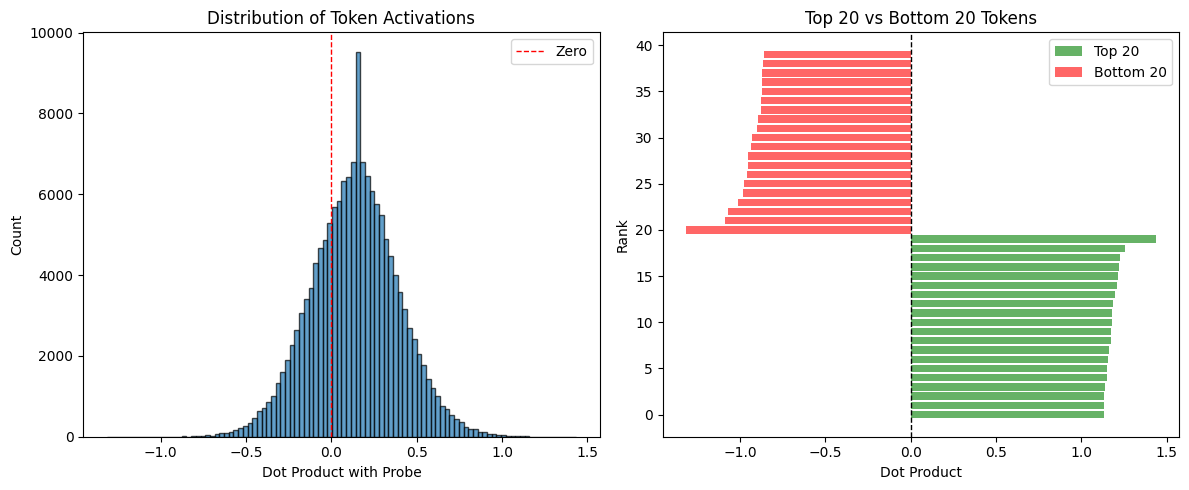

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(dot_products, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Dot Product with Probe')
plt.ylabel('Count')
plt.title('Distribution of Token Activations')
plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Zero')
plt.legend()

# Top/Bottom bars
plt.subplot(1, 2, 2)
plt.barh(range(20), top_scores[:20][::-1], color='green', alpha=0.6, label='Top 20')
plt.barh(range(20, 40), bottom_scores[:20], color='red', alpha=0.6, label='Bottom 20')
plt.xlabel('Dot Product')
plt.ylabel('Rank')
plt.title('Top 20 vs Bottom 20 Tokens')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.legend()

plt.tight_layout()
plt.show()

## 7. Save Results

In [ ]:
# Save to CSV
top_df.to_csv(f"{RESULTS_DIR}/top_tokens.csv", index=False)
bottom_df.to_csv(f"{RESULTS_DIR}/bottom_tokens.csv", index=False)

print(f"\nResults saved to:")
print(f"  - {RESULTS_DIR}/top_tokens.csv")
print(f"  - {RESULTS_DIR}/bottom_tokens.csv")

## 8. Interpretation

- **High dot product tokens**: These tokens, when they appear at the probe's position/layer, strongly activate in the direction the probe learned to associate with high success rate.
- **Low dot product tokens**: These tokens activate in the opposite direction

**Note**: This analysis uses the embedding matrix, so it shows tokens at the input level. The actual activations the probe sees are after being processed through layers of the transformer, so this is an approximation of what the probe detects.